# PETSc ARG

## Setup

First, check if you are at the correct project environment.

In [ ]:
using Pkg
Pkg.status()

Then check if all packages are installed and up to date:

In [ ]:
Pkg.update()

In [3]:
using ExperimentalDesign, StatsModels, GLM, DataFrames, Distributions, Random, StatsPlots

# Designs with Categorical Factors

In [4]:
design_distribution = DesignDistribution((ksp_type = CategoricalFactor(["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]),
        pc_type = CategoricalFactor(["jacobi", "sor", "bjacobi", "mg"])))

DesignDistribution
Formula: 0 ~ ksp_type + pc_type
Factor Distributions:
ksp_type: CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)

pc_type: CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)


In [13]:
design = rand(design_distribution, 300)
f = @formula 0 ~ ksp_type + pc_type
optimal_design = OptimalDesign(design, f, 10)

OptimalDesign
Dimension: (10, 2)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [167, 217, 56, 17, 83, 135, 22, 18, 3, 71]
Optimality Criteria: Dict(:D => 0.0040416881870204945)
Design Matrix:
10×2 DataFrame
│ Row │ ksp_type │ pc_type │
│     │ String   │ String  │
├─────┼──────────┼─────────┤
│ 1   │ tcqmr    │ jacobi  │
│ 2   │ tfqmr    │ bjacobi │
│ 3   │ cgs      │ bjacobi │
│ 4   │ tfqmr    │ jacobi  │
│ 5   │ bcgs     │ sor     │
│ 6   │ gcr      │ jacobi  │
│ 7   │ gmres    │ mg      │
│ 8   │ fcg      │ jacobi  │
│ 9   │ cr       │ jacobi  │
│ 10  │ cg       │ jacobi  │

Plot design

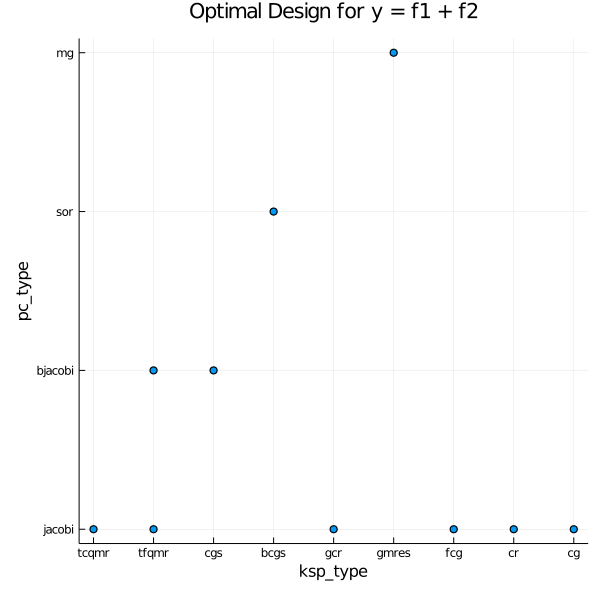

In [14]:
@df optimal_design.matrix scatter(:ksp_type,
    :pc_type,
    size = (600, 600),
    xlabel = "ksp_type",
    ylabel = "pc_type",
    legend = false,
    title = "Optimal Design for y = f1 + f2")

## Target Application Parameters

In [7]:
cmd_prefix = ["singularity", "exec", "--nv", "../container/petsc-gpu.sif", "make", "-s", "-C", "../src"]
dev = "core"
np = 4
res = 100

100

## Response Function

In [15]:
# x is a set of flags
function y(x)
    parameters = []
    for i in 1:length(x)
        push!(parameters, rstrip(string(uppercase(string(keys(x)[i])), "=", x[i], " ")))
    end
    
    cmd = `$cmd_prefix $[dev, "NP=$np", "RES=$res"] $parameters`

    main_stage = parse(Float64, chomp(read(cmd, String)))
    return main_stage
end

y (generic function with 1 method)

In [16]:
optimal_design.matrix[!, :response] = y.(eachrow(optimal_design.matrix))

10-element Array{Float64,1}:
 0.086247
 0.061137
 0.057774
 0.06684
 0.055202
 0.23577
 0.076309
 0.069621
 0.055567
 0.05551

In [12]:
print(optimal_design)

OptimalDesign
Dimension: (10, 3)
Factors: (ksp_type = CategoricalFactor(
values: ["cg", "gmres", "fcg", "tcqmr", "cgs", "bcgs", "tfqmr", "cr", "gcr"]
distribution: DiscreteUniform(a=1, b=9)
)
, pc_type = CategoricalFactor(
values: ["jacobi", "sor", "bjacobi", "mg"]
distribution: DiscreteUniform(a=1, b=4)
)
)
Formula: 0 ~ ksp_type + pc_type
Selected Candidate Rows: [34, 92, 119, 280, 13, 152, 38, 18, 28, 14]
Optimality Criteria: Dict(:D => 0.0041211423277284324)
Design Matrix:
10×3 DataFrame
│ Row │ ksp_type │ pc_type │ response     │
│     │ String   │ String  │ String       │
├─────┼──────────┼─────────┼──────────────┤
│ 1   │ tfqmr    │ mg      │ 8.6167e-02\n │
│ 2   │ tfqmr    │ jacobi  │ 6.6242e-02\n │
│ 3   │ tcqmr    │ mg      │ 1.5196e-01\n │
│ 4   │ cr       │ mg      │ 7.1395e-02\n │
│ 5   │ gmres    │ sor     │ 6.8333e-02\n │
│ 6   │ fcg      │ bjacobi │ 1.2228e-01\n │
│ 7   │ bcgs     │ bjacobi │ 5.6484e-02\n │
│ 8   │ gcr      │ jacobi  │ 1.9389e-01\n │
│ 9   │ cg       │ s